# Mixture of Gaussians with R2JAGS

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
   0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [1]:
# Loading R2jags
require(R2jags)

#set a random seed
set.seed(0)

#set plot dimensions
options(repr.plot.width=10,repr.plot.height=8)

Loading required package: R2jags

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




First of all, let's define the parameters of the problem to be solved.

In [2]:
sample_size<- 20000 # Number of experiments we will perform
n_throws<- 10 # Number of times each coin is spinned
m_heads<- 3 # Number of heads obtained

Then we can define the model. It consists of a mixture of three Beta distributions becoming a Beta-Bernoulli model.

The objective is to learn that distribution from an independent sequence of experiments, so it can be modelled as a Binomial distribution of size `n` with probability defined by the Beta-Bernoulli distribution.

The likelihood is:
$$ x \sim \binomdist(\text{size}=n,\text{prob}=\theta)$$

with the prior distribution
$$ \theta \sim 0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10) $$



Define the Mixture of Beta distributions

In [3]:
# Let's define the parameters of the mixture prior
prior.alpha1<-10
prior.beta1<-20
prior.alpha2<-15
prior.beta2<-15
prior.alpha3<-20
prior.beta3<-10
prior.gamma1<-0.5
prior.gamma2<-0.2
prior.gamma3<-0.3

In [4]:
# List of parameters of our model, loaded before.
Mix.01.dat<-list(a1=prior.alpha1,b1=prior.beta1,a2=prior.alpha2,b2=prior.beta2,b3=prior.beta3,a3=prior.alpha3
                 ,gamma1=prior.gamma1,gamma2=prior.gamma2,gamma3=prior.gamma3,n=n_throws,x=m_heads)

In [5]:
# JAGS model
cat(
"model
    {
    x~dbin(p,n)            
    p<-theta[r]
    r~dcat(g[])
    theta[1]~dbeta(a1,b1) 
    theta[2]~dbeta(a2,b2)
    theta[3]~dbeta(a3,b3)
    g[1]<-gamma1
    g[2]<-gamma2
    g[3]<-gamma3
    }"
    ,file="Mix.01.jag")

In [6]:
Mix.01.m1<-jags(data=Mix.01.dat, n.chains=4,n.iter=3500,n.burnin=500, 
        parameters.to.save=c("theta","p"), model.file="Mix.01.jag")

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 4
   Total graph size: 17

Initializing model



In [7]:
thetas<-Mix.01.m1$BUGSoutput$sims.list$theta

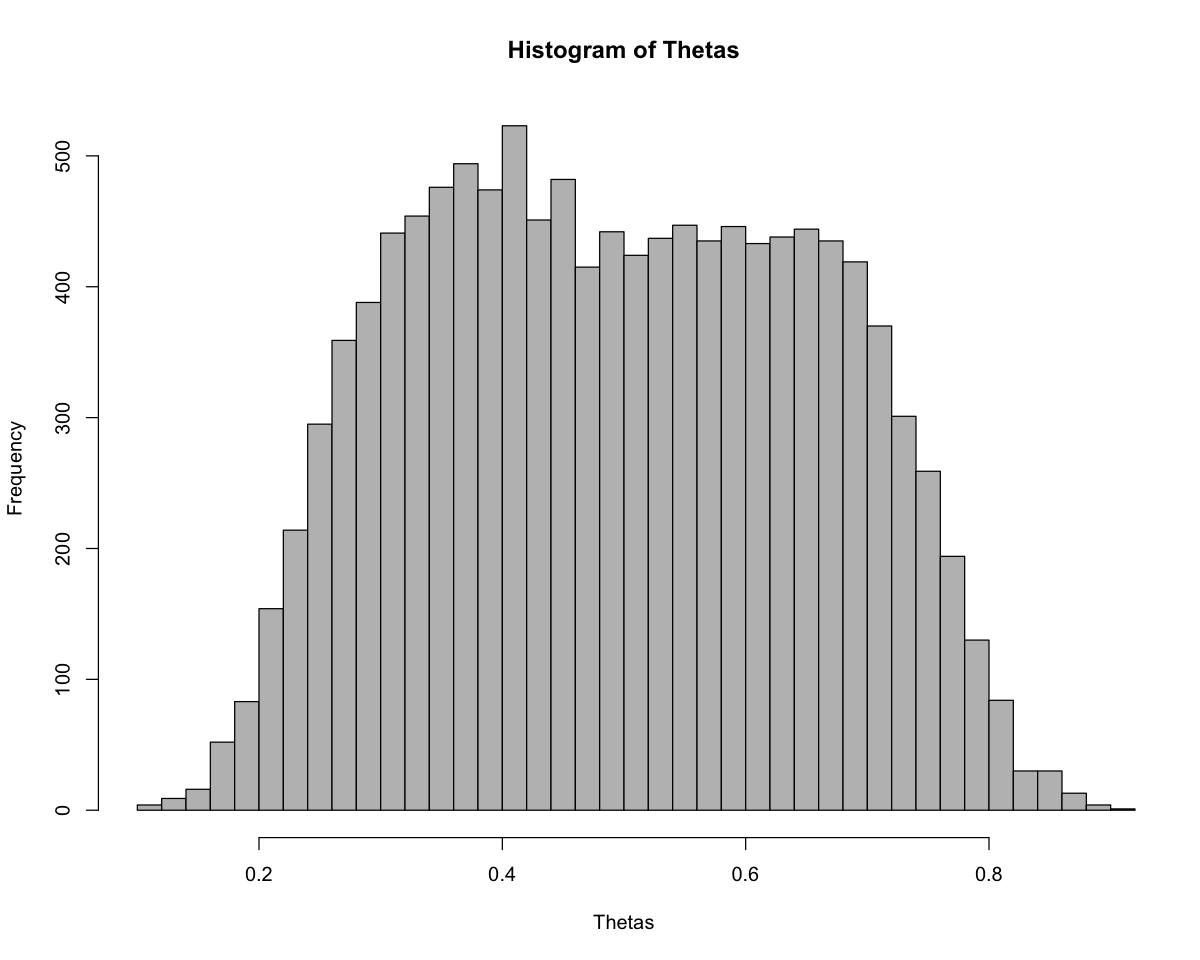

In [8]:
hist(thetas,
main="Histogram of Thetas",
breaks=50,
xlab="Thetas",
xlim=c(0.1,0.9),
col="grey",
freq=TRUE
)

Flip a coin `m` times and output the frequency of heads and the priopr predictive pmf for the simulation

[1] "Absolute frequency of m heads:"


heads
   0    1    2    3    4    5    6    7    8    9   10 
 269 1014 2195 3006 3411 3357 2760 2015 1295  539  139 

[1] "Relative frequency of m heads:"


heads
      0       1       2       3       4       5       6       7       8       9 
0.01345 0.05070 0.10975 0.15030 0.17055 0.16785 0.13800 0.10075 0.06475 0.02695 
     10 
0.00695 

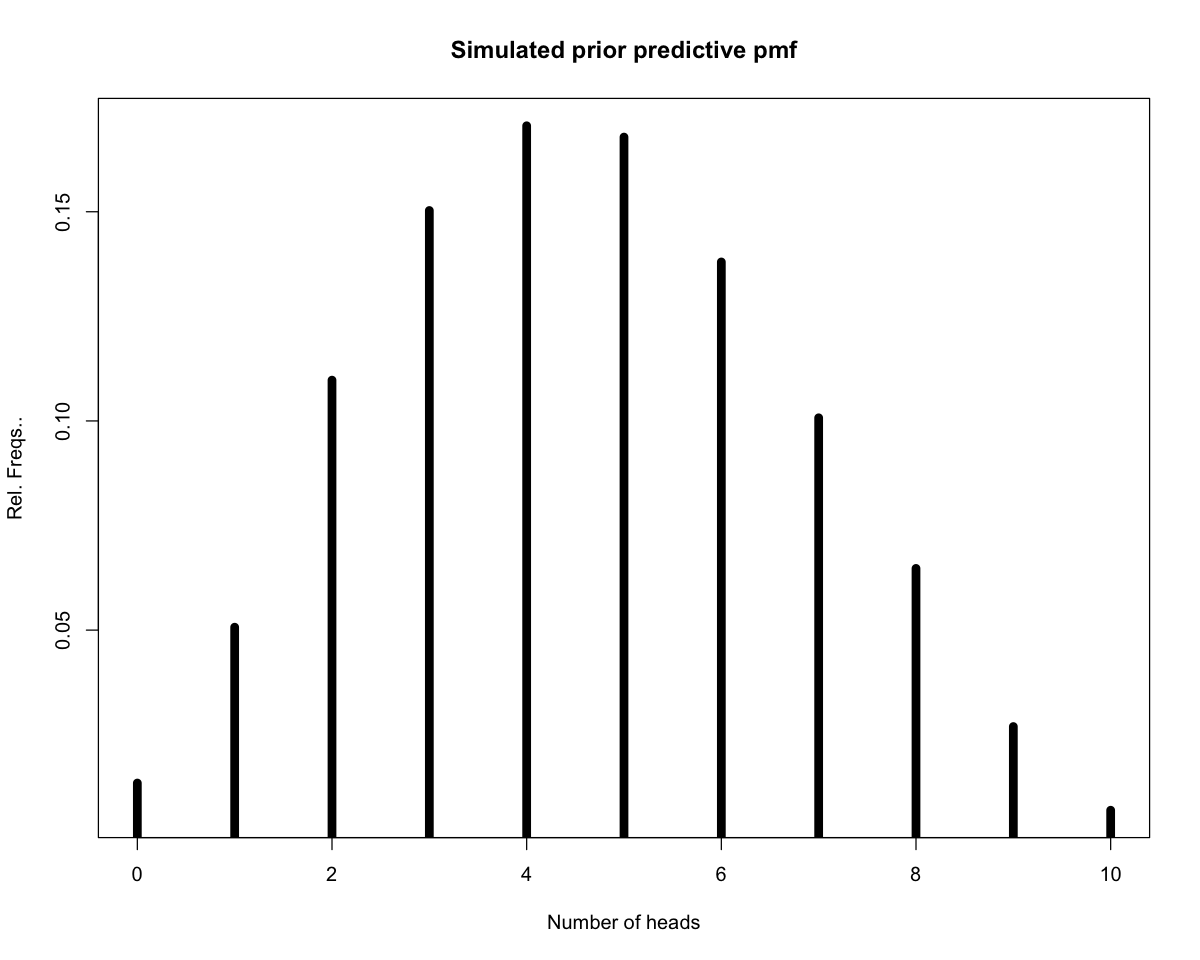

In [16]:
# Number of heads in m trials
heads <- rbinom(n = sample_size, size = n_throws, prob = thetas)

# Absolute frequencies
print("Absolute frequency of m heads:")
table(heads)

# Relative frequencies. 
print("Relative frequency of m heads:")
f <- table(heads)/sum(table(heads))
f
matplot(x=names(f),y=f,type="h",lwd=7, lty=1,
        xlab="Number of heads",ylab="Rel. Freqs..",
        main="Simulated prior predictive pmf")

Finally, with the aim to study the probability of having $m=3$ heads given theta, all cases resulting in $m=3$ heads are picked and the histogram of thetas producing `m` heads is plotted.

In [10]:
p.sample<-Mix.01.m1$BUGSoutput$sims.list$p
thetas.m.heads<-p.sample

In [11]:
# Cases in which we get m=3 heads
print(paste0("Number of times we got m = 3 heads: ", table(heads)[4]))

# Proportion of cases in which we get m=3 heads
print(paste0("Proportion of samples with m=3 heads: ", f[4]))

[1] "Number of times we got m = 3 heads: 2996"
[1] "Proportion of samples with m=3 heads: 0.1498"


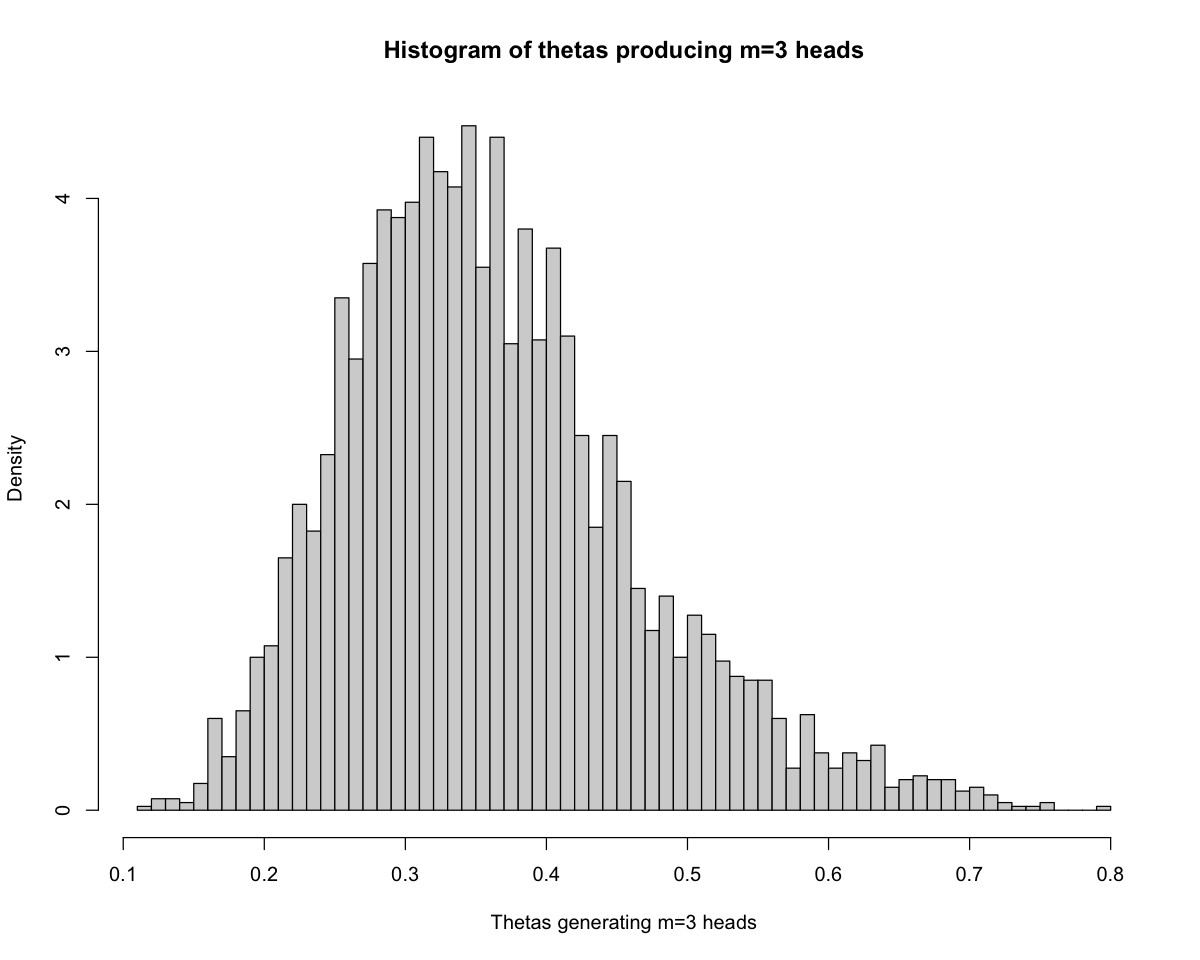

In [12]:
hist(thetas.m.heads,breaks=50, freq=FALSE, main="Histogram of thetas producing m=3 heads", xlab = "Thetas generating m=3 heads")

Given this experiments, we can make the **analysis of the posterior quantities**.

### MAP estimator of $\theta$
Given the simulation performed before, we can estimate the MAP as the theta value with maximal density.

[1] "Simulated MAP: 0.328"


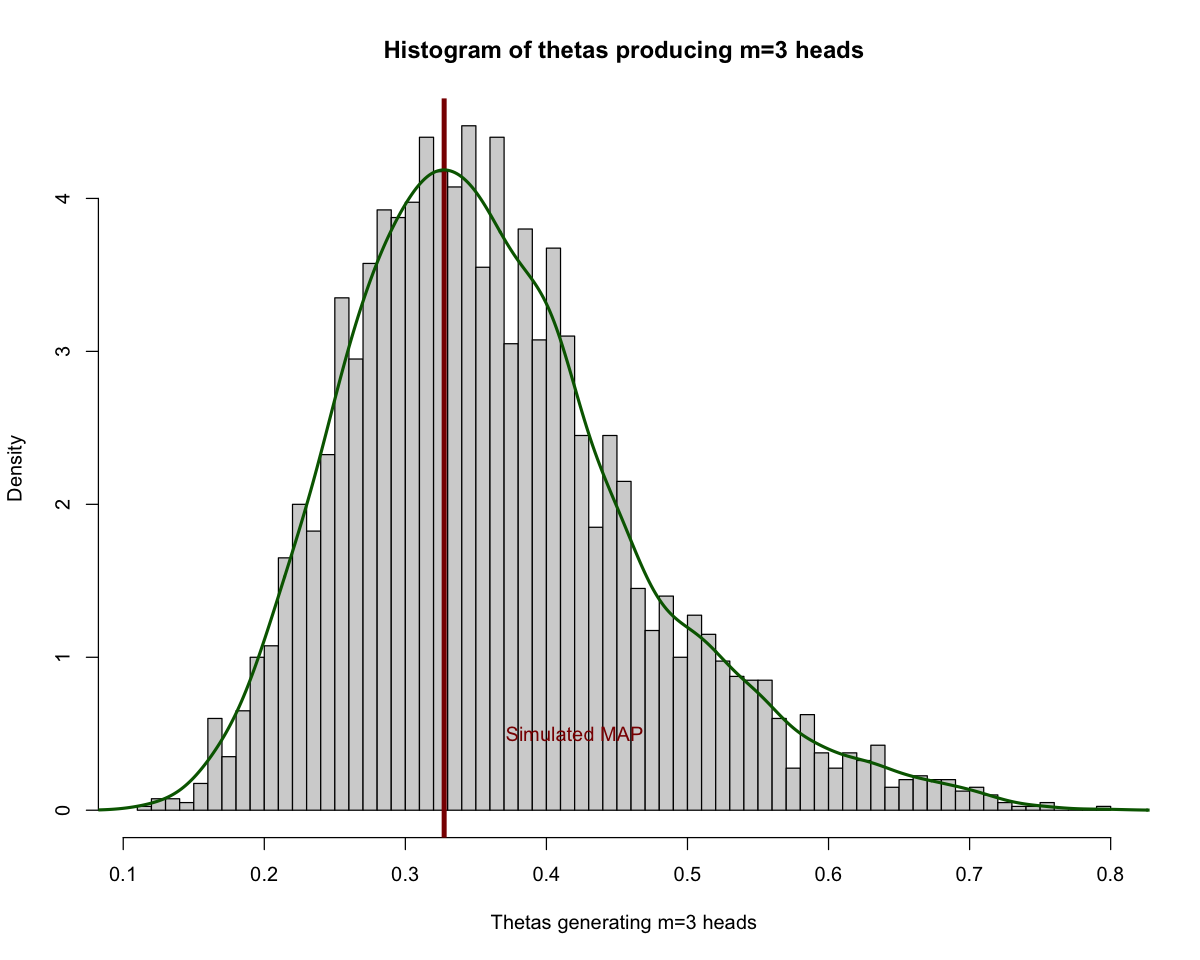

In [13]:
# Finding the maximum a posteriori (MAP)
# Finding MAP
thetas.m.heads.density <-density(p.sample)
Sim.MAP <- thetas.m.heads.density$x[which.max(thetas.m.heads.density$y)]

# Plot over histogram
hist(thetas.m.heads, breaks=50, freq=FALSE, main="Histogram of thetas producing m=3 heads", xlab = "Thetas generating m=3 heads")
abline(v=Sim.MAP,col="DarkRed",lwd=4)
lines(thetas.m.heads.density$x,thetas.m.heads.density$y,lwd=2.5,col="DarkGreen")
text(0.42, 0.5, "Simulated MAP", col="DarkRed")
print(paste0("Simulated MAP: ", round(Sim.MAP,3)))

### Posterior Expectation
Again, the simulation allows us to compute the posterior expectation as shown in the following cell.

In [14]:
# Simulated Expectation 
print(paste0("Simulation based posterior expectation: ",round(mean(thetas.m.heads),8)))

[1] "Simulation based posterior expectation: 0.36235161"


### Posterior Variance
And also the posterior variance as shown in the following cell.

In [15]:
# Simulated Variance
print(paste0("Simulation based posterior variance: ",round(var(thetas.m.heads),8)))

[1] "Simulation based posterior variance: 0.01081858"
